In [1]:
import pandas as pd
import torch

In [2]:
# 1. 加载数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# 2. 拆分标签列
train_labels = train_data['SalePrice']
train_data = train_data.drop(['SalePrice'], axis=1)
print(train_labels.shape)
print(train_data.shape)
print(test_data.shape)

(1460,)
(1460, 80)
(1459, 80)


In [4]:
# 3. 合并 train/test（便于统一处理）
all_features = pd.concat((train_data.drop(['Id'], axis=1),
                          test_data.drop(['Id'], axis=1)))
print(all_features.shape)

(2919, 79)


In [5]:
# 4. 找出数值型列
numeric_feats = all_features.dtypes[all_features.dtypes != "object"].index

In [6]:
# 5. 数值列缺失值填 0
all_features[numeric_feats] = all_features[numeric_feats].fillna(0)

In [7]:
# 6. 类别列做 one-hot 编码，dummy_na=True 表示把 NaN 当成一类
all_features = pd.get_dummies(all_features, dummy_na=True)

In [8]:
# 7. 全部转为 float32，避免 object 类型报错
all_features = all_features.astype('float32')

In [9]:
# 8. 切分回训练集和测试集（转为张量）
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values)
test_features = torch.tensor(all_features[n_train:].values)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1), dtype=torch.float32)
print(train_features.shape)
print(test_features.shape)

torch.Size([1460, 330])
torch.Size([1459, 330])


In [10]:
import torch.nn as nn

def get_net():
    net = nn.Sequential(nn.Linear(train_features.shape[1], 1))
    return net

In [11]:
def log_rmse(net, features, labels):
    # 预测值限制最小为1（避免 log(0)）
    clipped_preds = torch.clamp(net(features), min=1)
    rmse = torch.sqrt(nn.MSELoss()(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = nn.MSELoss()(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        test_ls.append(log_rmse(net, test_features, test_labels))
    
    return train_ls, test_ls, net

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42)

In [15]:
net = get_net()
train_ls, valid_ls, trained_net = train(net, X_train, y_train, X_valid, y_valid,
                                        num_epochs=100, learning_rate=0.01, weight_decay=0, batch_size=64)

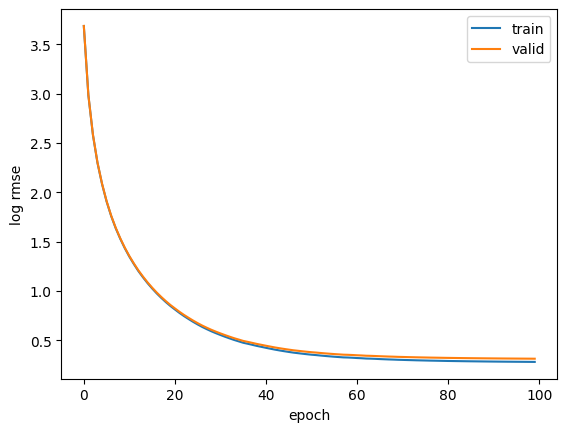

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_ls, label='train')
plt.plot(valid_ls, label='valid')
plt.xlabel('epoch')
plt.ylabel('log rmse')
plt.legend()
plt.show()